<a href="https://colab.research.google.com/github/AarnoStormborn/Tensorflow-Developer-Certification/blob/main/04_tensorflow_transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow: Feature Extraction

In [1]:
!nvidia-smi

Mon Jan  9 15:28:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.2


## Data Acquisition

In [3]:
# (10% of 10_food_classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the download
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-01-09 15:28:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.9MB/s    in 7.9s    

2023-01-09 15:28:27 (20.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



## Inspect the data

In [4]:
# Walk through the directories
import os
BASE_DIR = "10_food_classes_10_percent"
for dirpath, dirnames, filenames in os.walk(BASE_DIR):
    print(f"{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

2 directories and 0 images in '10_food_classes_10_percent'
10 directories and 0 images in '10_food_classes_10_percent/train'
0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'
0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
0 directories and 75 images in '10_food_classes_10_percent/train/steak'
0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
10 directories and 0 images in '10_food_classes_10_percent/test'
0 directories and 250 images in '10_food_classes_10_

### Load the images 

In [5]:
# Load the images into batches using ImageDataGenerators

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set hyperparameters
IMAGE_SHAPE = (256,256)
BATCH_SIZE = 32

# Set directories
train_dir = BASE_DIR + '/train/'
test_dir = BASE_DIR + '/test/'

# Create Datagens
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load images
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              shuffle=True)

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size=IMAGE_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up Callbacks

Tensorflow Callbacks are functions or blocks of code which are executed during a specific instant while training a Deep Learning model  \
Some popular callbacks:
* Tracking experiments with Tensorboard
* Model checkpoint with ModelCheckpoint callback
* Stopping a model before finishing all epochs with EarlyStopping callback





In [6]:
# Create tensorboard callback
import datetime

def tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name +'/' + experiment_name + '/' + datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saved to {log_dir}")
    return tb_callback

## Creating Models with Tensorflow Hub

Previously, we created our own models from scratch using Tensorflow. Now, we will use pretrained models that are available on Tensorflow Hub https://tfhub.dev/

**Note**: Find research papers on Deep Learning: https://paperswithcode.com/

For our First Transfer Learning Model, we will use EfficientNetB0 Feature Vector: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

And also Resnet50 Feature Vector: https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [19]:
# Let's compare the two models
effnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [8]:
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# Create a function to create model from URL
def create_model(model_url, num_classes=10):
    """
    Take tensorflow hub URL and create Sequential model with it

    Args:
        model_url (str): TensorFlow Hub URL
        num_classes (int): Number of classes in the dataset. default 10

    Returns:
        An uncompiled Keras Sequential model
    """
    # Get the Pretrained Model
    feature_layer = hub.KerasLayer(model_url,
                                   trainable=False,
                                   name="feature_extraction_layer",
                                   input_shape=IMAGE_SHAPE+(3,))
    
    # Create Keras Model
    model = tf.keras.Sequential([
        feature_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model


### ResNet50V2 Model

In [10]:
# Create ResNet model using the function
resnet_model = create_model(resnet_url)

# Compile the model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

# Fit the model
resnet_history = resnet_model.fit(train_set,
                                  epochs=5,
                                  steps_per_epoch=len(train_set),
                                  validation_data=test_set,
                                  validation_steps=len(test_set),
                                  callbacks=[tensorboard_callback(dir_name="tensorflow_hub",
                                                                  experiment_name="resnet50v2")])

Saved to tensorflow_hub/resnet50v2/09012023-152841
Epoch 1/5
24/24 [==============================] - 31s 832ms/step - loss: 1.8971 - accuracy: 0.3653 - val_loss: 1.2011 - val_accuracy: 0.6364
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.8930 - accuracy: 0.7507 - val_loss: 0.8399 - val_accuracy: 0.7460
Epoch 3/5
24/24 [==============================] - 17s 738ms/step - loss: 0.6211 - accuracy: 0.8360 - val_loss: 0.7272 - val_accuracy: 0.7732
Epoch 4/5
24/24 [==============================] - 17s 739ms/step - loss: 0.4688 - accuracy: 0.8987 - val_loss: 0.6765 - val_accuracy: 0.7956
Epoch 5/5
24/24 [==============================] - 17s 744ms/step - loss: 0.3771 - accuracy: 0.9240 - val_loss: 0.6387 - val_accuracy: 0.8012


In [11]:
# Check model summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
# Function to plot loss curves
def plot_curves(history):

    """
    Returns separate loss and accuracy curves
    """
    import matplotlib.pyplot as plt

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

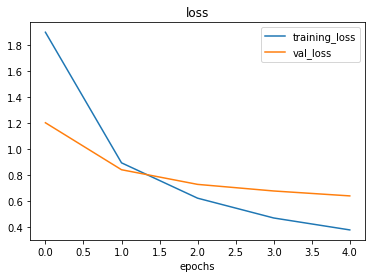

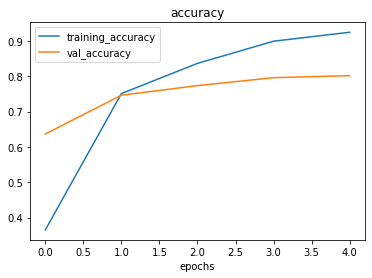

In [15]:
plot_curves(resnet_history)

In [16]:
resnet_model.evaluate(test_set)

79/79 [==============================] - 14s 172ms/step - loss: 0.6387 - accuracy: 0.8012


[0.6386926770210266, 0.8011999726295471]

### EfficientNetB0 Model

In [20]:
# Create a EfficientNet model
effnet_model = create_model(effnet_url)

# Compile the model
effnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

# Fit the model
effnet_history = effnet_model.fit(train_set,
                                  epochs=5,
                                  steps_per_epoch=len(train_set),
                                  validation_data=test_set,
                                  validation_steps=len(test_set),
                                  callbacks=[tensorboard_callback(dir_name="tensorflow_hub",
                                                                  experiment_name="efficientnetb0")])

Saved to tensorflow_hub/efficientnetb0/09012023-162843
Epoch 1/5
24/24 [==============================] - 27s 770ms/step - loss: 1.8541 - accuracy: 0.4147 - val_loss: 1.3111 - val_accuracy: 0.7140
Epoch 2/5
24/24 [==============================] - 16s 692ms/step - loss: 1.0743 - accuracy: 0.7747 - val_loss: 0.8713 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 16s 694ms/step - loss: 0.7663 - accuracy: 0.8360 - val_loss: 0.6980 - val_accuracy: 0.8476
Epoch 4/5
24/24 [==============================] - 16s 699ms/step - loss: 0.6180 - accuracy: 0.8587 - val_loss: 0.6102 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 17s 710ms/step - loss: 0.5248 - accuracy: 0.8880 - val_loss: 0.5554 - val_accuracy: 0.8640


In [21]:
effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


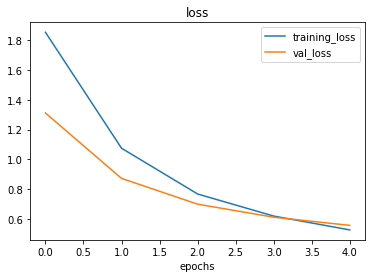

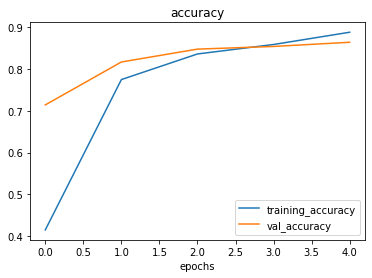

In [22]:
plot_curves(effnet_history)

In [23]:
effnet_model.evaluate(test_set)

79/79 [==============================] - 13s 161ms/step - loss: 0.5554 - accuracy: 0.8640


[0.5553562045097351, 0.8640000224113464]

In [25]:
# Number of layers in EfficientNetB0
len(effnet_model.layers[0].weights)

309

## Types of Transfer Learning

* **Direct Transfer Learning** : Using an entire model with no changes
* **Feature Extraction**: Using features learned by other models in the form of feature vectors to create our own output
* **Fine Tuned Transfer Learning**: Use the pretrained model with customizations to some/all of its layers 

## Compare model results with TensorBoard

In [28]:
# Upload records to TensorBoard dev
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs ResNet50V2" \
--description "Experiment to compare two prominent Transfer Learning models" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=pibEqsZyl7ClpivRgYHkp9572IkQTN&prompt=consent&access_type=off

In [29]:
# Check all experiments
!tensorboard dev list

https://tensorboard.dev/experiment/XUKn3ImkT9CAjTBgdxwILw/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Experiment to compare two prominent Transfer Learning models
	Id                   XUKn3ImkT9CAjTBgdxwILw
	Created              2023-01-09 16:55:51 (8 minutes ago)
	Updated              2023-01-09 16:55:56 (8 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5794895
Total: 1 experiment(s)


In [30]:
# Delete an experiment
# !tensorboard dev delete --experiment_id XUKn3ImkT9CAjTBgdxwILw